In [1]:
from notebook.services.config import ConfigManager
cfm = ConfigManager()
cfm.update('livereveal', {
              'theme': 'simple',
              'transition': 'convex',
              'start_slideshow_at': 'selected'
})

{'start_slideshow_at': 'selected', 'theme': 'simple', 'transition': 'convex'}

# Python Analysis Figures
Author: Barron H. Henderson

In [2]:
# Prepare my slides
%pylab inline
%cd working

Populating the interactive namespace from numpy and matplotlib
/Users/barronh/Downloads/GCandPython/working


# Data for Figures

In this exercise, we will use publicly available data to create some pretty plots that combine GEOS-Chem results with observations from the DC8 aircraft on the DC3 campaign.

In a minute, not yet, we are going to download the data.

# Downloads DC3 Observations

Download Merged Observations from DC8 aircraft during the DC3 campaign.

In [3]:
%mkdir icartt
!curl -Lo icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict http://www-air.larc.nasa.gov/cgi-bin/enzFile?e38EE03EFAE02C04F06E9647DAF98F48D6A2f7075622d6169722f534541433452532d4443332f4d45524745532f315f4d494e5554452e4443385f4d52472f6463332d6d726736302d6463385f6d657267655f32303132303531385f52375f7468727532303132303632322e696374

mkdir: cannot create directory ‘icartt’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.5M  100 30.5M    0     0  1227k      0  0:00:25  0:00:25 --:--:-- 1327k


# Download GEOS-Chem Benchmark

Benchmark data is available from Harvard's website as below

```
!curl -LO ftp.as.harvard.edu/gcgrid/geos-chem/1yr_benchmarks/v10-01/v10-01-public-release/Run0/tracerinfo.dat
!curl -LO ftp.as.harvard.edu/gcgrid/geos-chem/1yr_benchmarks/v10-01/v10-01-public-release/Run0/diaginfo.dat
!curl -LO ftp.as.harvard.edu/gcgrid/geos-chem/1yr_benchmarks/v10-01/v10-01-public-release/Run0/bpch.tar.gz
```

# Smaller, Faster Downloads



In [4]:
!curl -LO ftp.as.harvard.edu/gcgrid/geos-chem/1yr_benchmarks/v10-01/v10-01-public-release/Run0/tracerinfo.dat
!curl -LO ftp.as.harvard.edu/gcgrid/geos-chem/1yr_benchmarks/v10-01/v10-01-public-release/Run0/diaginfo.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83324  100 83324    0     0  47062      0  0:00:01  0:00:01 --:--:-- 47102
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13840  100 13840    0     0   8686      0  0:00:01  0:00:01 --:--:--  8704


```
!curl -LO ftp://data.as.essie.ufl.edu/pub/exch/GCandPython/working/bpch.zip
```

In [5]:
import zipfile
zf = zipfile.ZipFile('bpch.zip')
zf.extract('bpch/ctm.bpch.v10-01-public-Run0.2013050100')

'/Users/barronh/Downloads/GCandPython/working/bpch/ctm.bpch.v10-01-public-Run0.2013050100'

Unzip june too.

# CHECK POINT:
List the size of of the file you downloaded

# ANSWERS Hidden

<div style="visibility: hidden">
ls -lh
ls -lh icartt
```
296M bpch/ctm.bpch.v10-01-public-Run0.2013050100
296M bpch/ctm.bpch.v10-01-public-Run0.2013060100
31M icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict
```
</div>

# Intro to the Common Data Model

1. files and groups
2. dimensions
3. properties
4. variables
5. Conventions
  * IOAPI and WRF-IOAPI
  * COARDS
  * Climate Forecasting (CF) Conventions
6. Conceptualizing any data set as CDM

# pncdump returns the common data language

```
--header : don't show data
-f ffi1001 : format is NASA AMES ffi1001
-v VAR1,VAR2,...,VARN : only show these variables
```

For archiving, I am only dumping 3 variables. Try omitting -v

In [6]:
!pncdump.py --header -v Fractional_Day,UTC,O3_ESRL -f ffi1001 icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict

PseudoNetCDF.core._files.PseudoNetCDFFile icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict {
dimensions:
        POINTS = 6817 ;

variables:
        double Fractional_Day(POINTS);
                Fractional_Day:units = "Fractional_Day, none" ;
                Fractional_Day:fill_value = -999999.0 ;
                Fractional_Day:llod_value = "N/A" ;
                Fractional_Day:scale = 1.0 ;
                Fractional_Day:llod_flag = -888888 ;
                Fractional_Day:standard_name = "Fractional_Day" ;
                Fractional_Day:ulod_flag = -777777 ;
                Fractional_Day:missing_value = -999999 ;
                Fractional_Day:ulod_value = "N/A" ;
        double O3_ESRL(POINTS);
                O3_ESRL:units = "ppbv" ;
                O3_ESRL:fill_value = -999999.0 ;
                O3_ESRL:llod_value = "N/A" ;
                O3_ESRL:scale = 1 ;
                O3_ESRL:llod_flag = -888888 ;
                O3_ESRL:standard_name = "O3_ESRL" ;
              

# CHECK POINT

1. List three attributes the IAS variable have (hint: use -v IAS)?

    -
    
2. What are IAS units?

    -
    
3. What attributes does the file have?

    -
     

# Common Processing and Terminology

This section will explain many of the techniques used in the tile plot section and in all subsequent sections.

1. slicing in numpy
2. dimensional reductions
3. Loading data from different formats
  * CMAQ (already done)
  * CAMx, WRF, GEOS-Chem, CSV, NASA AMES, AQS
4. Adding coordinate variables
5. Using named dimensions via PseudoNetCDF
6. Adding derived variables via PseudoNetCDF

## Time series

Make time series plots with 3 different methods from CMAQ data.

1. Python Environment
2. Python with PseudoNetCDF
3. Command Line Interface (terminal or DOS)
4. Advanced users will add observations
5. Advanced users will add another species on a secondary axis
6. Advanced users will repeat with CAMx or GEOS-Chem

# Python Environment

1. Start easy with a 2-d line plot
2. Add real data
3. Transform data to time.

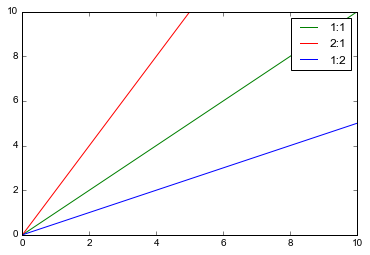

In [7]:
close()
plot([0,10], [0,10], linestyle = '-', color = 'g', label = '1:1')
plot([0,5], [0,10], linestyle = '-', color = 'r', label = '2:1')
plot([0,10], [0,5], linestyle = '-', color = 'b', label = '1:2')
legend()
#savefig('temp.png')

# Python with real data

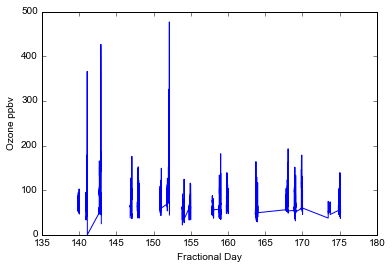

In [8]:
from PseudoNetCDF import PNC
args = PNC('--format=ffi1001', \
           'icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict')
infile = args.ifiles[0]
fdays = infile.variables['Fractional_Day']
o3 = infile.variables['O3_ESRL']
close()
plot(fdays, o3)
xlabel('Fractional Day')
ylabel('Ozone ' + o3.units)
?tick_params

# Python with date

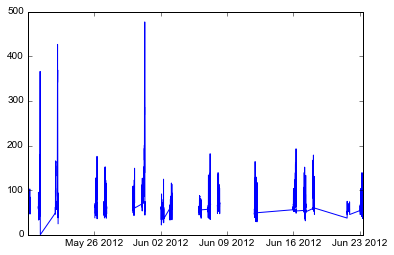

In [9]:
import datetime
from PseudoNetCDF import PNC
args = PNC('--format=ffi1001', 'icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict')
infile = args.ifiles[0]
fdays = infile.variables['Fractional_Day']
o3 = infile.variables['O3_ESRL']
offset = datetime.datetime(2011, 12, 31).timestamp()
xdate = [datetime.datetime.utcfromtimestamp(offset + fday * 24*3600) \
         for fday in fdays]
plot(xdate, o3);

# Python with pretty date

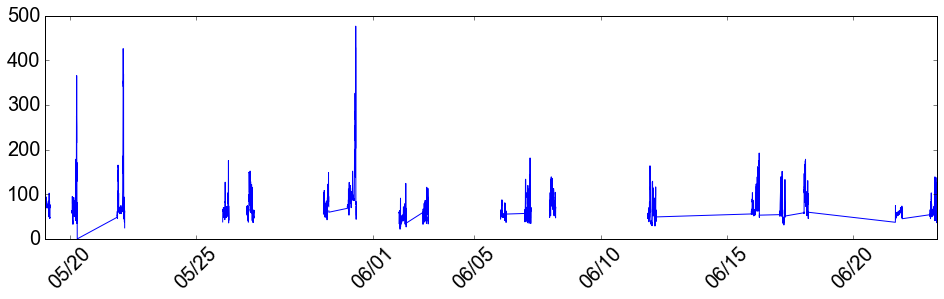

In [10]:
import datetime
from PseudoNetCDF import PNC
args = PNC('--format=ffi1001', 'icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict')
infile = args.ifiles[0]
fdays = infile.variables['Fractional_Day']
o3 = infile.variables['O3_ESRL']
offset = datetime.datetime(2011, 12, 31).timestamp()
xdate = [datetime.datetime.utcfromtimestamp(offset + fday * 24*3600) \
         for fday in fdays]
figure(figsize = (16, 4))
tick_params(axis = 'both', labelsize = 20, )
plot(xdate, o3)
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(\
                                    bymonthday = [1, 5, 10, 15, 20, 25]))
plt.setp(ax.get_xticklabels(), rotation = 45);

# Timeseries using PNC

Your goal: Make a time series plot like the one above using the command line.

![](working/tsoneO3_ESRL.png)

In [11]:
!pncts.py \
    --matplotlibrc="figure.figsize=16,6"\
    --format=ffi1001 -v O3_ESRL --coordkeys Fractional_Day \
    --expr "time=Fractional_Day" \
    --expr "time.units='days since 2011-12-31'"\
    icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict dc3ts

**PNC://anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519:UserWarning:
  No labelled objects found. Use label='...' kwarg on individual plots.
dc3tsO3_ESRL.png


In [12]:
%ls dc3ts*

dc3tsO3_ESRL.png


## Scatter Plots

1. Python Environment (replace plot with scatter, utc with some other variable)
2. Python with PseudoNetCDF
3. Command Line Interface (terminal or DOS) (replace pncts.py with pncscatter.py)
4. Advanced users will switch from time/space paired to rank paired

# Tile Plots

Make tile plots of ozone with 3 different methods from CMAQ data.

1. Python Environment
2. Python with PseudoNetCDF
3. Command Line Interface (terminal or DOS)
4. Advanced users will overlay observations
5. Advanced users will repeat with CAMx or GEOS-Chem

# Python only

In [13]:
from PseudoNetCDF import PNC
args = PNC("--format=bpch,vertgrid='GEOS-5-NATIVE',nogroup=('IJ-AVG-$',)",
           "bpch/ctm.bpch.v10-01-public-Run0.2013050100")
infile = args.ifiles[0]
latb = infile.variables['latitude_bounds']
lonb = infile.variables['longitude_bounds']
ozone = infile.variables['O3'][:, 0].mean(0)

In [14]:
lone = np.append(lonb[0,0], lonb[:, 1])
late = np.append(latb[0,0], latb[:, 1])
LON, LAT = np.meshgrid(lone, late)

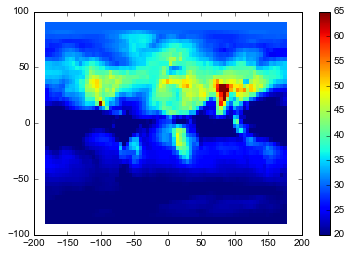

In [15]:
close()
pcolor(LON, LAT, ozone, vmin = 20, vmax = 65)
colorbar();

# With PNC Mapping

In [16]:
from PseudoNetCDF.coordutil import getmap
m = getmap(infile, resolution = 'c')

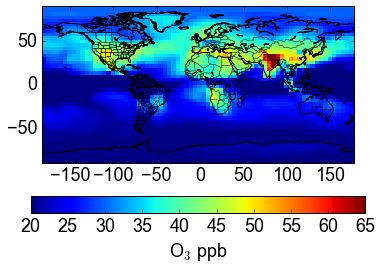

In [17]:
rcParams['font.size'] = 18
close()
m.pcolor(LON, LAT, ozone, vmin = 20, vmax = 65)
m.drawcoastlines()
m.drawcountries()
m.drawstates() # What options does this take?
cb = plt.colorbar(orientation = 'horizontal', label = 'O$_3$ ppb')

# CLI PseudoNetCDF

In [18]:
!pncmap.py -v O3 -f "bpch,nogroup=('IJ-AVG-$',)" \
-s layer72,0 -r time,mean --norm="Normalize(vmin=0,vmax=80)" \
bpch/ctm.bpch.v10-01-public-Run0.2013050100 srfmap
%ls srfmap*

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/geoschemfiles/_bpch.py:866:UserWarning:
  vertgrid selected (GEOS-5-REDUCED) and output layers are not consistent; update to GEOS-5-NATIVE (e.g., bpch(..., vertgrid='GEOS-5-NATIVE') -f "bpch,vertgrid='GEOS-5-NATIVE'"
srfmapO3.png


![Simple Tile Plot](working/srfmapO3.png)

# Overlay Observations and Model 

# Find the range of space and time covered by the observations.

This is our first look at observations from the Common Data Model perspective. Remember: dimensions, properties, and variables (which have dimensions and properties).

# Make a map with just GEOS-Chem

pncmap.py is the primary map maker. Like all other pnc commands, it uses options that can be reviewed with --help. It shares all the same slicing, aggregating functions, but it also has a few options that are not included else where.

$ pncmap.py --help

Review the following options

- --matplotlibrc
- --figure-keywords
- --axes-keywords
- --plot-commands
- --figformat
- --norm
- --colorbar-formatter
- --overlay
- --resolution
- --no-countries, --states, --counties
- --shapefile
- --no-squeeze
- --iter

## Start by plotting the whole world for ozone at the 500 hPa

What layer is approximately 500 hPa?

In [19]:
!pncdump.py -v etam_pressure --full-indices c -f bpch bpch/ctm.bpch.v10-01-public-Run0.2013050100

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/geoschemfiles/_bpch.py:866:UserWarning:
  vertgrid selected (GEOS-5-REDUCED) and output layers are not consistent; update to GEOS-5-NATIVE (e.g., bpch(..., vertgrid='GEOS-5-NATIVE') -f "bpch,vertgrid='GEOS-5-NATIVE'"
PseudoNetCDF.core._files.PseudoNetCDFFile bpch/ctm.bpch.v10-01-public-Run0.2013050100 {
dimensions:
        layer = 47 ;
        layer_bounds = 48 ;
        longitude = 72 ;
        latitude = 46 ;
        time = UNLIMITED // (1 currently) 
        nv = 2 ;
        tnv = 2 ;

variables:
        double etam_pressure(layer);
                etam_pressure:units = "hPa" ;
                etam_pressure:standard_name = "atmosphere_hybrid_sigma_pressure_coordinate" ;
                etam_pressure:base_units = "hPa" ;
                etam_pressure:var_desc = "etam_pressure" ;
                etam_pressure:long_name = "etam_pressure" ;
        float layer_bounds(layer_bounds);
                layer_bounds:units = "level

### Fill in the options below to plot May ozone at the surface

In [26]:
!pncmap.py -f "bpch,nogroup=('IJ-AVG-\$',)" -v O3 -s layer72,? \
    bpch/ctm.bpch.v10-01-public-Run0.2013050100 map500hPa_

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/geoschemfiles/_bpch.py:866:UserWarning:
  vertgrid selected (GEOS-5-REDUCED) and output layers are not consistent; update to GEOS-5-NATIVE (e.g., bpch(..., vertgrid='GEOS-5-NATIVE') -f "bpch,vertgrid='GEOS-5-NATIVE'"
**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/plotutil/pncmap.py:85:UserWarning:
  Autoselect deciles colormap of O3; override width --norm


![](working/map500hPa_O3.png)

#### CHECK POINT:

- What warning do you get? How can you solve it?
- What was the file name of the saved figure? (hint: use the --verbose option)
- How could you change the pncmap.py call so that the VARNAME was just O3 and the output had just O3 in the label.

### Plot the average May/June value

- What does the --stack option do?
- How could you combine it with the  -r option to plot the average ozone in May and June?

*Note: the -f options are broadcast to both the May and June files. If they were different format (e.g., GEOS-Chem and ICARTT), we would need to treat them separately.

# Make a Map with just DC3 Observations

Hint: pncmap.py expects latitude and longitude (case sensitive). You can use --expr or --rename to fix the case and --coordkeys to ensure these variables are not plotted and immune to -v.

# Combining PNC commands

Notice that the commands necessary to open ICARTT (ffi1001) and GEOS-Chem (bpch) files were different. We can separate commands and apply them only to one file using the --pnc option. Make notes below about the pnc option:

## Now use one command to make both maps.

* Hint 1: Rename O3_ESRL to O3
* Hint 2: Escaping quotes is important
* Hint 3: Use --expr to redefine DC2 longitude on -182.5, 177.5 use np.where

# ANSWERS Hidden

<div style="visibility: hidden">

```
pncmap.py --norm="Normalize(0, 100)" -v O3 \
--pnc " -f bpch,nogroup=(\'IJ-AVG-$\',),vertgrid=\'GEOS-5-NATIVE\' \
--stack=time -r time,mean -s layer72,22 -v O3 \
bpch/ctm.bpch.v10-01-public-Run0.2013050100 bpch/ctm.bpch.v10-01-public-Run0.2013060100" \
--pnc " -f ffi1001 --rename v,O3_ESRL,O3 --expr=\"latitude=LATITUDE;longitude=np.where(LONGITUDE>180,LONGITUDE-360,LONGITUDE)\" icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict" \
map
```

</div>

## Now lets make this map better!

- Focus in on the observations region
- Mask all observations that are not within the model layer pressures
- Add a title

# ANSWERS Hidden

<div style="visibility: hidden">
```
--overlay" option
--mask "where,PRESSURE&gt;515.7865" 
--mask "where,PRESSURE&lt;479.60059"
--axes-keywords "title='one'"
--plot-commands "plt.title('one')"
```
</div> 

# First make NetCDF copies of your results

In [27]:
!pncgen.py -O -f ffi1001 \
            --mask "where,PRESSURE>515.7865" \
            --mask "where,PRESSURE<479.60059" \
            --rename v,O3_ESRL,O3 --rename v,LATITUDE,latitude \
            -v Fractional_Day,O3_ESRL,LATITUDE,LONGITUDE,PRESSURE \
            --expr "longitude=np.where(LONGITUDE>180,LONGITUDE-360,LONGITUDE)" \
            --expr "time=Fractional_Day*24*3600" \
            --expr "time.units='seconds since 2011-12-31'" \
            icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict dc3.nc

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/pncgen.py:78:UserWarning:
  Could not add as of 01/12/2016. to file; <class 'AttributeError'>: NetCDF: Name contains illegal characters
**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/pncgen.py:78:UserWarning:
  Could not add (e.g., to eliminate duplication) to file; <class 'AttributeError'>: NetCDF: Name contains illegal characters


In [28]:
!pncgen.py -O -f "bpch,nogroup=('IJ-AVG-$',),vertgrid='GEOS-5-NATIVE'" \
         --stack=time -s latitude,28,36 -s longitude,10,25 \
         -s layer72,22 -r time,mean -v O3 \
         bpch/ctm.bpch.v10-01-public-Run0.2013050100 bpch/ctm.bpch.v10-01-public-Run0.2013060100 \
         bpch_500hPa.nc

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/core/_functions.py:831:UserWarning:
  Got duplicate variables for layer72 without stackable dimension; first value retained


# Now use the command line to make the plot

In [29]:
!pncmap.py --overlay --norm="Normalize(0, 100)" -v O3 \
 bpch_500hPa.nc dc3.nc dc3bpchmap
%ls dc3bpchmap*

**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/coordutil.py:181:UserWarning:
  Latitude bounds are approximate
dc3bpchmapO30.png  dc3bpchmapO31.png


![With Overlay](working/dc3bpchmapO31.png)

# Evaluate Model with Observations

In [33]:
!pncscatter.py -v O3 \
        --plot-commands="plt.xlabel('Obs')" \
        --plot-commands="plt.ylabel('Mod')" \
        dc3.nc bpch_500hPa.nc scat
!pnceval.py --funcs=MB,ME -v O3 dc3.nc bpch_500hPa.nc

dc3nc_0 = ifile0 = dc3.nc
bpch_5_0 = ifile1 = bpch_500hPa.nc
**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/pnceval.py:371:UserWarning:
  Assumes input order is obs model
**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/pnceval.py:378:UserWarning:
  Skipped MB;operands could not be broadcast together with shapes (1,1,8,15) (6817,) 
**PNC:/Users/barronh/Development/pseudonetcdf/src/PseudoNetCDF/pnceval.py:378:UserWarning:
  Skipped ME;operands could not be broadcast together with shapes (1,1,8,15) (6817,) 


![Scatter](working/scatO3.png)

In [25]:
!pnceval.py --help

usage: pnceval.py [-h] [--verbose] [--pnc PNC]
                  [-f {see --list-formats for choices}]
                  [--list-format] [--help-format HELPFORMAT]
                  [--sep] [--inherit] [--mangle]
                  [--rename RENAME]
                  [--remove-singleton REMOVESINGLETON]
                  [--coordkeys key1,key2]
                  [-v varname1[,varname2[,...,varnameN]]
                  [-a att_nm,var_nm,mode,att_typ,att_val]
                  [-m MASKS] [--from-convention FROMCONV]
                  [--to-convention TOCONV] [--stack STACK]
                  [--merge] [-s dim,start[,stop[,step]]]
                  [-r dim,function[,weight]]
                  [--mesh dim,weight,function]
                  [-c dim,mode,wgt1,wgt2,...wgtN] [-e EXTRACT]
                  [--extract-file EXTRACTFILE]
                  [--extractmethod {nn,linear,cubic,quintic,KDTree}]
                  [--op-typ OPERATORS] [--expr EXPRESSIONS]
                  [--exprscript EX

# Summary

You should be able to:
1. Open data of different types.
2. Characterize a dataset using the Common Data Language
3. Slice and reduce dimensions.
4. Create spatial plots with observations. 
5. Do a simple evaluation.
